In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [58]:
prices = pd.read_excel("etf_combined.xlsx", index_col="Date", parse_dates=True)
prices.columns = prices.columns.str.strip()


In [59]:
root_folder = "../raw"

ticker_column = "Ticker"
valid_extensions = [".csv", ".xlsx", ".xls"]

ticker_dict = {}

for dirpath, dirnames, filenames in os.walk(root_folder):
    tickers = []

    for file in filenames:
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_extensions:
            continue

        file_path = os.path.join(dirpath, file)
        try:
            if ext.lower() == ".csv":
                df = pd.read_csv(file_path)
            else:
                df = pd.read_excel(file_path)
            
            if ticker_column in df.columns:
                tickers.extend(df[ticker_column].dropna().astype(str).str.strip().unique())
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    if tickers:
        # Get the top-level folder under root_folder
        rel_path = os.path.relpath(dirpath, root_folder)
        top_folder = rel_path.split(os.sep)[0]  # 'equities', 'bonds', etc.

        if top_folder not in ticker_dict:
            ticker_dict[top_folder] = []
        ticker_dict[top_folder].extend(tickers)

# Optional: deduplicate tickers in each asset class
ticker_dict = {k: list(set(v)) for k, v in ticker_dict.items()}
print(ticker_dict)

{'bonds': ['CRHG LN', 'UBTP', 'EMHG', 'JGSA', 'AGGG LN'], 'alternatives': ['VICI', 'SGLN', 'DLR'], 'equities': ['GOAIGBIV', 'GAMSUZA ID', 'FFEDWGA LX', 'PSRU LN Equity', 'EMMV LN', 'CUKX LN', 'PIGEOZG LX', 'VGSESIE ID', 'SPMV LN', 'ARTGEIG LN', 'BGND4DS LX', 'IEFQ LN', 'TECW LN', 'PARAQPG LX', 'MVEU LN Equity', 'VUKE LN', 'WMVG LN']}


In [60]:
equities     = ticker_dict.get("equities", [])
bonds        = ticker_dict.get("bonds", [])
alternatives = ticker_dict.get("alternatives", [])

# Reorder the DataFrame
ordered = equities + bonds + alternatives
prices = prices[ordered]

# Compute daily log‐returns and correlation
rets = np.log(prices / prices.shift(1)).dropna()
corr = rets.corr()



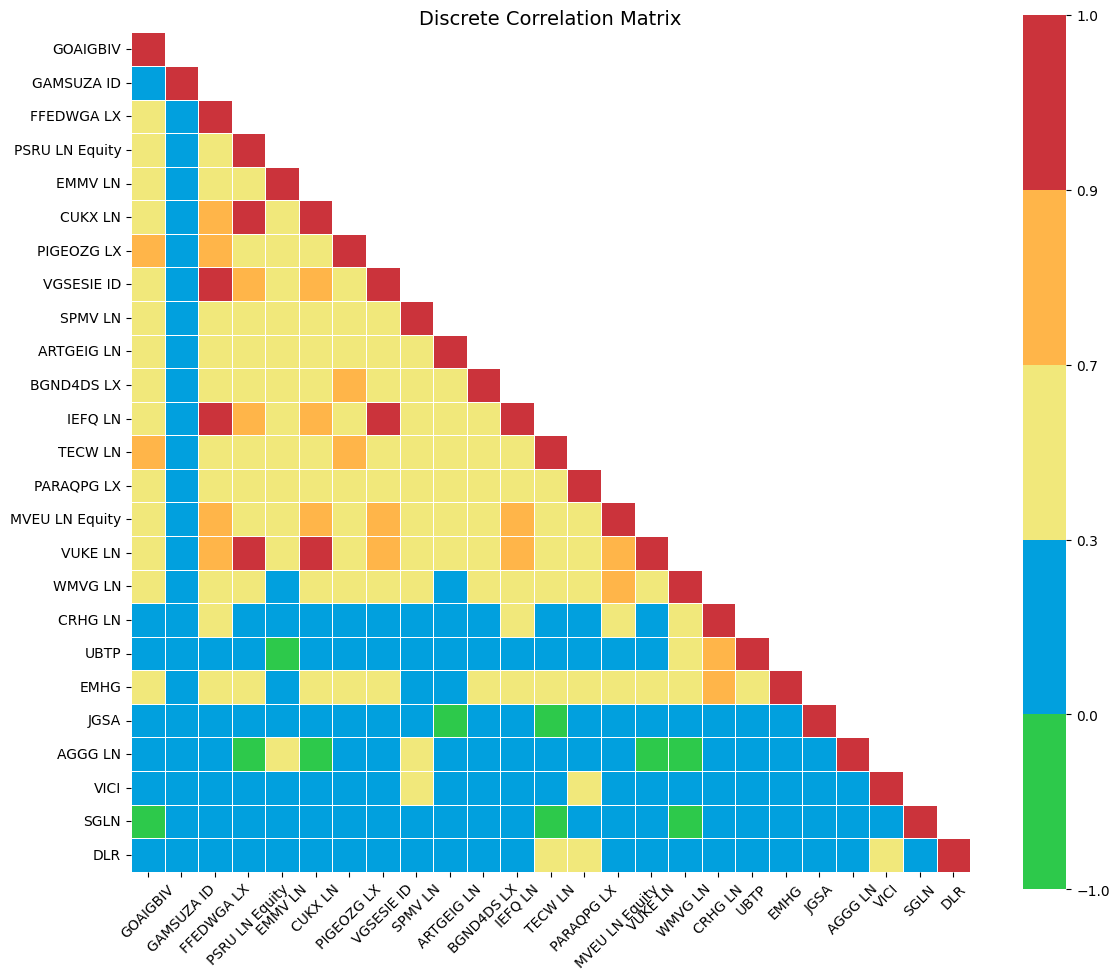

In [80]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Step 1: Define bins and custom colormap (from green to red)
bins = [-1.0, 0.0, 0.3, 0.7, 0.9, 1.0]
colors = ['#2DC94B', '#01A0DE', '#F1E87B', '#FFB549', '#CB333B']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bins, len(colors))

# Create masked heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=False, cmap=cmap, norm=norm,
            square=True, cbar=True, linewidths=0.5,
            xticklabels=True, yticklabels=True, mask=np.triu(np.ones_like(corr, dtype=bool), k=1))

# Optional: set better ticks
plt.xticks(rotation=45)
plt.title("Discrete Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join('..', '..', 'results', 'correlation_heatmap.png'), dpi=300)

Asset Categories:
  Equities: 17 assets
  Bonds: 5 assets
  Alternatives: 3 assets


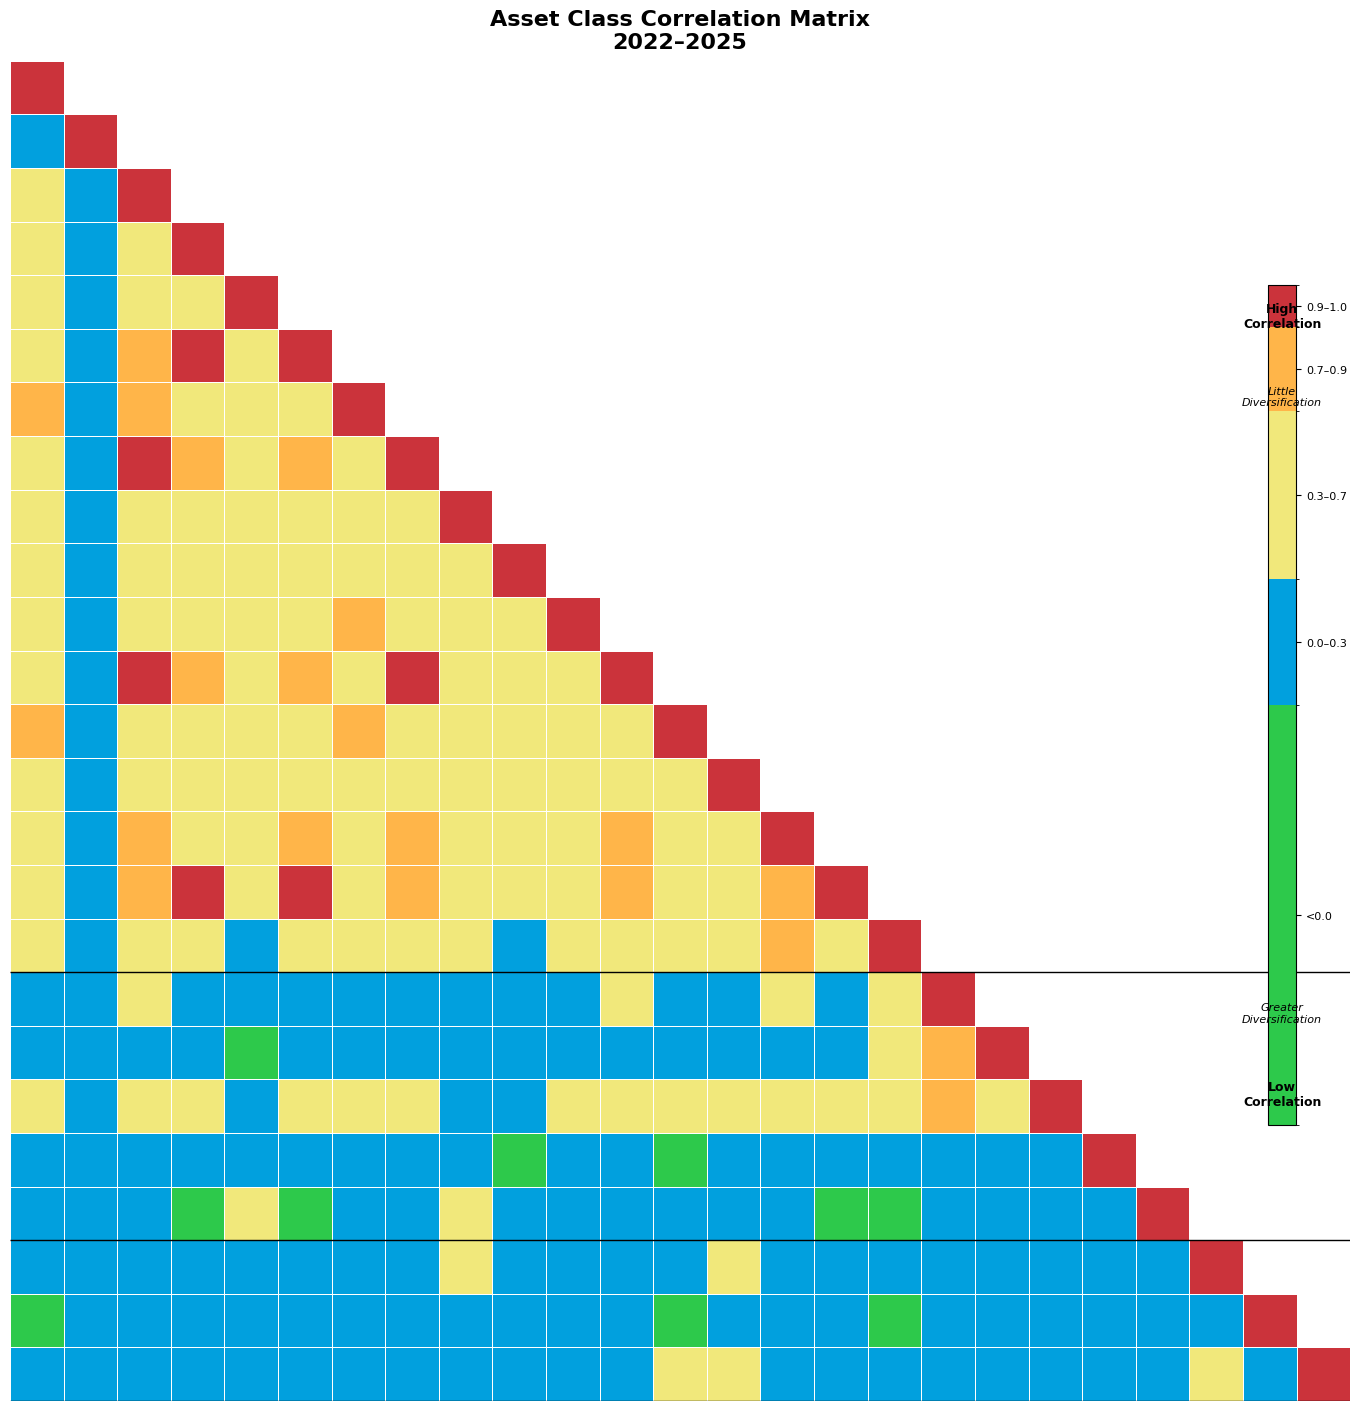

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colorbar import ColorbarBase

# ————————————————————————————————
# 1) Colormap & bins
# ————————————————————————————————
bins   = [-1.0, 0.0, 0.3, 0.7, 0.9, 1.0]
colors = ['#2DC94B', '#01A0DE', '#F1E87B', '#FFB549', '#CB333B']
cmap   = ListedColormap(colors)
norm   = BoundaryNorm(bins, ncolors=len(colors))

# ————————————————————————————————
# 2) Asset categories & ordering
#    (assumes you already have corr, rets, ticker_dict defined)
# ————————————————————————————————
asset_categories = {
    'Equities'     : ticker_dict.get("equities", []),
    'Bonds'        : ticker_dict.get("bonds", []),
    'Alternatives' : ticker_dict.get("alternatives", [])
}
# drop empties
asset_categories = {k:v for k,v in asset_categories.items() if v}

# build ordered_assets + category_positions
ordered_assets    = []
category_positions = {}
pos = 0
for cat, assets in asset_categories.items():
    avail = [a for a in assets if a in corr.index]
    if not avail:
        continue
    category_positions[cat] = (pos, pos + len(avail) - 1)
    ordered_assets += avail
    pos += len(avail)

# reorder the matrix
corr2 = corr.reindex(index=ordered_assets, columns=ordered_assets)
n     = len(ordered_assets)

# ————————————————————————————————
# 3) Mask upper triangle (show lower + diagonal)
# ————————————————————————————————
mask = np.triu(np.ones_like(corr2, dtype=bool), k=1)

# ————————————————————————————————
# 4) Draw the heatmap
# ————————————————————————————————
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)
sns.heatmap(
    corr2,
    mask=mask,
    cmap=cmap,
    norm=norm,
    cbar=False,
    square=True,
    linewidths=0.5,
    linecolor='white',
    xticklabels=False,
    yticklabels=False,
    ax=ax
)

# ————————————————————————————————
# 5) Numbered x‐axis ticks
# ————————————————————————————————
ax.set_xticks(np.arange(n) + 0.5)
ax.set_xticklabels(np.arange(1, n+1), rotation=90, fontsize=8, fontweight='bold')

# ax.xaxis.tick_top()                # move ticks & labels to the top
# ax.xaxis.set_label_position('top')

# ————————————————————————————————
# 6) “Quick‐fix” for category y‐labels & separators
# ————————————————————————————————
# compute midpoints of each category block
y_mids = [(start + end + 1) / 2 for (start, end) in category_positions.values()]
ax.set_yticks(y_mids)
ax.set_yticklabels(list(category_positions.keys()),
                   rotation=0, ha='right',
                   fontsize=10, fontweight='bold')

# draw horizontal separator lines
for _, (_, end) in category_positions.items():
    ax.hlines(end+1, 0, n, color='black', linewidth=1)

# ————————————————————————————————
# 7) Discrete colorbar on the right (and invert it)
# ————————————————————————————————
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cb = ColorbarBase(
    cax,
    cmap=cmap,
    norm=norm,
    boundaries=bins,
    ticks=[(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)],
    spacing='proportional',
    orientation='vertical'
)
cb.set_ticklabels(['<0.0', '0.0–0.3', '0.3–0.7', '0.7–0.9', '0.9–1.0'])
cb.ax.tick_params(labelsize=8)


# optional annotations on colorbar
cb.ax.annotate('High\nCorrelation',
               xy=(0.5, 0.98), xycoords='axes fraction',
               ha='center', va='top',
               fontsize=9, fontweight='bold')
cb.ax.annotate('Little\nDiversification',
               xy=(0.5, 0.88), xycoords='axes fraction',
               ha='center', va='top',
               fontsize=8, fontstyle='italic')
cb.ax.annotate('Low\nCorrelation',
               xy=(0.5, 0.02), xycoords='axes fraction',
               ha='center', va='bottom',
               fontsize=9, fontweight='bold')
cb.ax.annotate('Greater\nDiversification',
               xy=(0.5, 0.12), xycoords='axes fraction',
               ha='center', va='bottom',
               fontsize=8, fontstyle='italic')

# ————————————————————————————————
# 8) Title, margins & summary
# ————————————————————————————————
start, end = rets.index.min().year, rets.index.max().year
fig.suptitle(f'Asset Class Correlation Matrix\n{start}–{end}',
             fontsize=16, fontweight='bold')
ax.axis('off')

# give extra left‐margin for category labels
print("Asset Categories:")
for cat, assets in asset_categories.items():
    print(f"  {cat}: {sum(a in corr.index for a in assets)} assets")

plt.show()